In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import openmeteo_requests
import requests_cache
from datetime import date, timedelta

#### Read in Data

In [4]:
# Pfad zur Excel-Datei
excel_path = "gebundelte_eco_counter_fahrradzaehler_bw.xlsx"

# Excel-Datei einlesen
df = pd.read_excel(excel_path)

# Zeilen filtern, deren 'data_description' "CSV" enthält
filtered_df = df[df['data_description'].str.contains("CSV", case=False, na=False)]

# URLs extrahieren
url_list = filtered_df['data_download_url'].dropna().tolist()

# Ausgabe (optional)
#for url in url_list:
#    print(url)

general_columns = pd.read_csv(url_list[1]).columns.tolist()

# Erstelle CSV-Datei, in der Daten aller URLs gespeichert werden
all_data = pd.DataFrame()
for url in url_list:
    csv_data = pd.read_csv(url)
    assert list(csv_data.columns) == general_columns, f"Spalten stimmen nicht überein in {url}"
    all_data = pd.concat([all_data, csv_data], ignore_index=True)

# Speichere all_data lokal als CSV-Datei
all_data.to_csv("alle_fahrradzaehler_daten.csv", index=False)   
all_data.head() 

C:\Users\grube\AppData\Local\Temp\ipykernel_9276\110034623.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)
C:\Users\grube\AppData\Local\Temp\ipykernel_9276\110034623.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)
C:\Users\grube\AppData\Local\Temp\ipykernel_9276\110034623.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)
C:\Users\grube\AppData\Local\Temp\ipykernel_9276\110034623.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)


,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2013-01-01T01:00:00+0000,2013-01-01T01:00:00+0100,15,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
1,2013-01-01T02:00:00+0000,2013-01-01T02:00:00+0100,17,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
2,2013-01-01T03:00:00+0000,2013-01-01T03:00:00+0100,14,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
3,2013-01-01T04:00:00+0000,2013-01-01T04:00:00+0100,13,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
4,2013-01-01T05:00:00+0000,2013-01-01T05:00:00+0100,9,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301


In [7]:
# Einlesen von alle_fahrradzaehler_daten.csv
data = pd.read_csv("alle_fahrradzaehler_daten.csv")
data.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2013-01-01T01:00:00+0000,2013-01-01T01:00:00+0100,15,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
1,2013-01-01T02:00:00+0000,2013-01-01T02:00:00+0100,17,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
2,2013-01-01T03:00:00+0000,2013-01-01T03:00:00+0100,14,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
3,2013-01-01T04:00:00+0000,2013-01-01T04:00:00+0100,13,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
4,2013-01-01T05:00:00+0000,2013-01-01T05:00:00+0100,9,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301


In [21]:
# Check data 
print(data.info())
#print(data.describe())
#print(data.isnull().sum())
#print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16827970 entries, 0 to 16827969
Data columns (total 16 columns):
 #   Column           Dtype              
---  ------           -----              
 0   timestamp        datetime64[ns, UTC]
 1   iso_timestamp    object             
 2   zählstand        int64              
 3   stand            int64              
 4   standort         object             
 5   channel_name     object             
 6   channel_id       int64              
 7   counter_site     object             
 8   counter_site_id  int64              
 9   domain_name      object             
 10  domain_id        int64              
 11  longitude        float64            
 12  latitude         float64            
 13  timezone         object             
 14  interval         int64              
 15  counter_serial   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(6), object(7)
memory usage: 2.0+ GB
None


In [5]:
# Convert column 'timestamp'into datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
# Prüfen, ob die konvertierung erfolgreich war
print(data['timestamp'].head())

0   2013-01-01 01:00:00+00:00
1   2013-01-01 02:00:00+00:00
2   2013-01-01 03:00:00+00:00
3   2013-01-01 04:00:00+00:00
4   2013-01-01 05:00:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]


In [6]:
# Check for duplicates
duplicates = data.duplicated()
print(f"Anzahl der Duplikate: {duplicates.sum()}")

Anzahl der Duplikate: 0


#### Data Info

In [7]:
# Number of years in the dataset
data['year'] = data['timestamp'].dt.year
print(f"Jahre im Datensatz: {data['year'].nunique()} - {data['year'].unique()}")

Jahre im Datensatz: 12 - [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [8]:
# Locations in data set
locations = data['standort'].unique()
print(f"Anzahl der Standorte: {len(locations)}")
print(f"Standorte:")
for loc in locations:
    print(loc)

Anzahl der Standorte: 19
Standorte:
Stadt Karlsruhe
Stadt Freiburg
Landeshauptstadt Stuttgart
Stadt Tübingen
Stadt Lörrach
Stadt Heilbronn
Stadt Mannheim
Stadt Kirchheim unter Teck
Stadt Heidelberg
Stadt Offenburg
Stadt Ludwisburg
Stadt Konstanz
Landkreis Böblingen
Ravensburg TWS GmbH and Co KG
Stadt Ulm
Stadtverwaltung Aalen
Stadt Reutlingen
Landratsamt Rems-Murr-Kreis
Stadt Singen


Note: counter = Gerät, channel = Richtung/Messspur

In [12]:
# Check the amount of counters per location
counters_per_location = data.groupby('standort').agg(
    anzahl_counter=('counter_serial', 'nunique'),
    counter_sites=('counter_site', lambda x: ', '.join(sorted(set(x))))
).reset_index()

print("Anzahl der Zähler pro Standort:") 
counters_per_location

Anzahl der Zähler pro Standort:


,standort,anzahl_counter,counter_sites
0,Landeshauptstadt Stuttgart,14,"Am Kräherwald, Böblinger Straße, Inselstraße, ..."
1,Landkreis Böblingen,2,"K 1077 Radschnellweg Böblingen-Ehningen, Römer..."
2,Landratsamt Rems-Murr-Kreis,8,Backnang (Plattenwald) - Oppenweiler Straße (K...
3,Ravensburg TWS GmbH and Co KG,7,"01 / 02 WGT Doggenriedstraße, 03 WGT Krankenha..."
4,Stadt Freiburg,3,"FR1 Dreisam / Otto-Wels-Str., FR2 Güterbahn / ..."
5,Stadt Heidelberg,7,"Bahnstadtpromenade, Berliner Straße Querschnit..."
6,Stadt Heilbronn,4,"Neckarbogen, Neckarufer, Route Nord, Route Süd"
7,Stadt Karlsruhe,1,Erbprinzenstraße
8,Stadt Kirchheim unter Teck,1,Barometer Kirchheim u. Teck
9,Stadt Konstanz,5,"Alte Rheinbrücke, Bahnhaltepunkt Fürstenberg, ..."


In [18]:
counters_per_location = data.groupby('standort')['counter_site_id'].nunique()
counters_per_location

standort
Landeshauptstadt Stuttgart       15
Landkreis Böblingen               2
Landratsamt Rems-Murr-Kreis       8
Ravensburg TWS GmbH and Co KG     7
Stadt Freiburg                    4
Stadt Heidelberg                 15
Stadt Heilbronn                   4
Stadt Karlsruhe                   1
Stadt Kirchheim unter Teck        1
Stadt Konstanz                    5
Stadt Ludwisburg                 15
Stadt Lörrach                     2
Stadt Mannheim                   14
Stadt Offenburg                   1
Stadt Reutlingen                  8
Stadt Singen                      1
Stadt Tübingen                    3
Stadt Ulm                         1
Stadtverwaltung Aalen             1
Name: counter_site_id, dtype: int64

In [11]:
# Check, at which location (standort) counter_serial is null
null_serial_locations = data[data['counter_serial'].isnull()]['standort'].unique()
print(f"Standorte mit null counter_serial: {null_serial_locations}")

Standorte mit null counter_serial: ['Stadt Freiburg' 'Stadt Mannheim' 'Stadt Heidelberg'
 'Landeshauptstadt Stuttgart' 'Stadt Offenburg' 'Stadt Ludwisburg']


#### Plots

##### Number counts per Location per Year

In [83]:
# Check yearly number of counts per standort 

# Extract date from timestamp
data['date'] = data['timestamp'].dt.date

# Step 1: Get max zählstand per standort, counter_serial, and date
max_per_counter = data.groupby(['standort', 'counter_serial', 'date'])['zählstand'].max().reset_index()

# Step 2: Sum these maxima per standort and date
daily_counts = max_per_counter.groupby(['standort', 'date'])['zählstand'].sum().reset_index()
daily_counts = daily_counts.rename(columns={'zählstand': 'daily_counts'})

# Step 3: Now aggregate to yearly counts
daily_counts['year'] = pd.to_datetime(daily_counts['date']).dt.year
yearly_counts = daily_counts.groupby(['standort', 'year'])['daily_counts'].sum().reset_index()
yearly_counts = yearly_counts.rename(columns={'daily_counts': 'yearly_counts'})

print("Jährliche Zählungen pro Standort:")
yearly_counts

Jährliche Zählungen pro Standort:


,standort,year,yearly_counts
0,Landeshauptstadt Stuttgart,2013,39795
1,Landeshauptstadt Stuttgart,2014,73765
2,Landeshauptstadt Stuttgart,2015,82236
3,Landeshauptstadt Stuttgart,2016,73662
4,Landeshauptstadt Stuttgart,2017,74043
...,...,...,...
144,Stadtverwaltung Aalen,2020,79
145,Stadtverwaltung Aalen,2021,5158
146,Stadtverwaltung Aalen,2022,7684
147,Stadtverwaltung Aalen,2023,6774


C:\Users\kessl\AppData\Local\Temp\ipykernel_31256\2605318302.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(standorte))


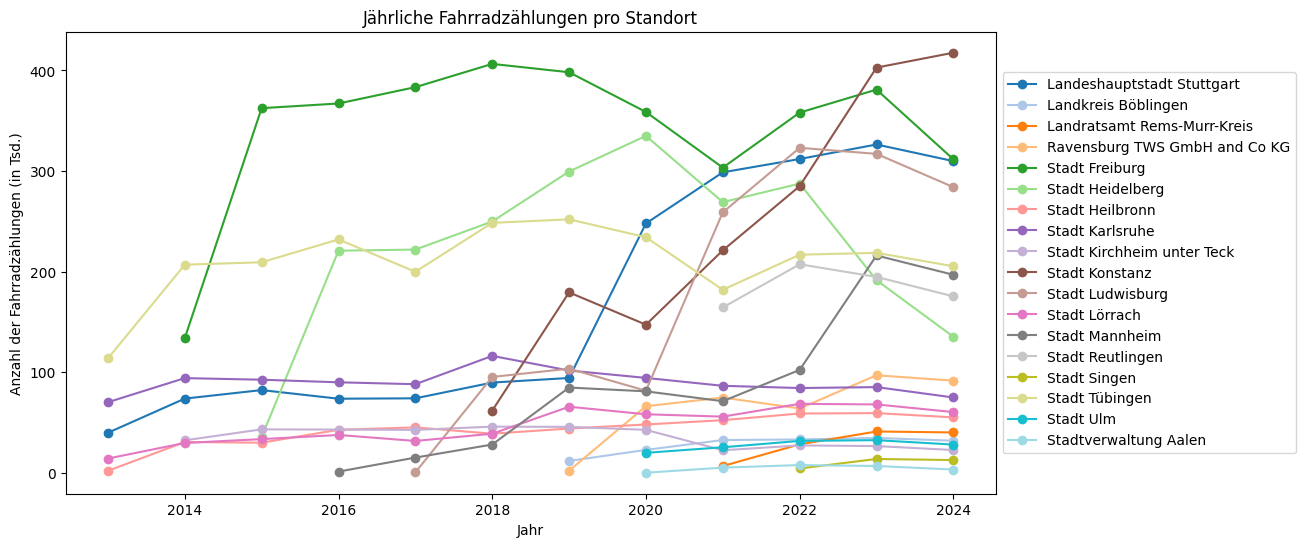

In [67]:
# Plot the yearly counts per standort
def thousands(x, pos):
    return f'{int(x/1000)}'

standorte = yearly_counts['standort'].unique()
colors = cm.get_cmap('tab20', len(standorte))  

plt.figure(figsize=(12, 6))
for i, standort in enumerate(standorte):
    subset = yearly_counts[yearly_counts['standort'] == standort]
    plt.plot(subset['year'], subset['yearly_counts'], marker='o', 
             label=standort, color=colors(i))

plt.title("Jährliche Fahrradzählungen pro Standort")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Fahrradzählungen (in Tsd.)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# For Konstanz, check how many counters there are per year
konstanz_data = data[data['standort'] == 'Stadt Konstanz']
counters_per_year_konstanz = konstanz_data.groupby('year')['counter_serial'].nunique()
counters_per_year_konstanz

year
2018    1
2019    1
2020    1
2021    3
2022    3
2023    5
2024    5
Name: counter_serial, dtype: int64

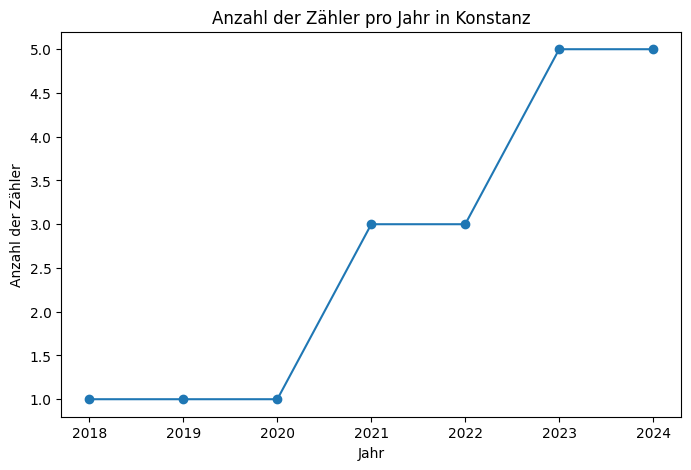

In [48]:
# Plot the number of counters per year in Konstanz
plt.figure(figsize=(8, 5))
plt.plot(counters_per_year_konstanz.index, counters_per_year_konstanz.values, marker='o')
plt.title("Anzahl der Zähler pro Jahr in Konstanz")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Zähler")
plt.show()

In [84]:
## Normalize counts per location by number of counters

# First, calculate number of active counters per standort and date i.e. counters that have non-null zählstand on that date as max value
active_counters = data.groupby(['standort', 'counter_serial', 'date'])['zählstand'].max().reset_index()
active_counters = active_counters[active_counters['zählstand'].notnull()]
active_counters = active_counters.groupby(['standort', 'date'])['counter_serial'].nunique().reset_index()
active_counters = active_counters.rename(columns={'counter_serial': 'num_active_counters'})

# Merge mit daily_counts
daily_counts = daily_counts.merge(active_counters, on=['standort', 'date'], how='left')

# Normalize daily counts
daily_counts['normalized_daily_counts'] = daily_counts['daily_counts'] / daily_counts['num_active_counters']


# Aggregate to yearly normalized counts
normalized_yearly_counts = daily_counts.groupby(['standort', 'year'])['normalized_daily_counts'].sum().reset_index()
normalized_yearly_counts = normalized_yearly_counts.rename(columns={'normalized_daily_counts': 'normalized_yearly_counts'})

print("Normalisierte jährliche Zählungen pro Standort:")
normalized_yearly_counts

Normalisierte jährliche Zählungen pro Standort:


,standort,year,normalized_yearly_counts
0,Landeshauptstadt Stuttgart,2013,39795.0
1,Landeshauptstadt Stuttgart,2014,36882.5
2,Landeshauptstadt Stuttgart,2015,41118.0
3,Landeshauptstadt Stuttgart,2016,36831.0
4,Landeshauptstadt Stuttgart,2017,37021.5
...,...,...,...
144,Stadtverwaltung Aalen,2020,79.0
145,Stadtverwaltung Aalen,2021,5158.0
146,Stadtverwaltung Aalen,2022,7684.0
147,Stadtverwaltung Aalen,2023,6774.0


C:\Users\kessl\AppData\Local\Temp\ipykernel_31256\1848293564.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(standorte))  # Colormap


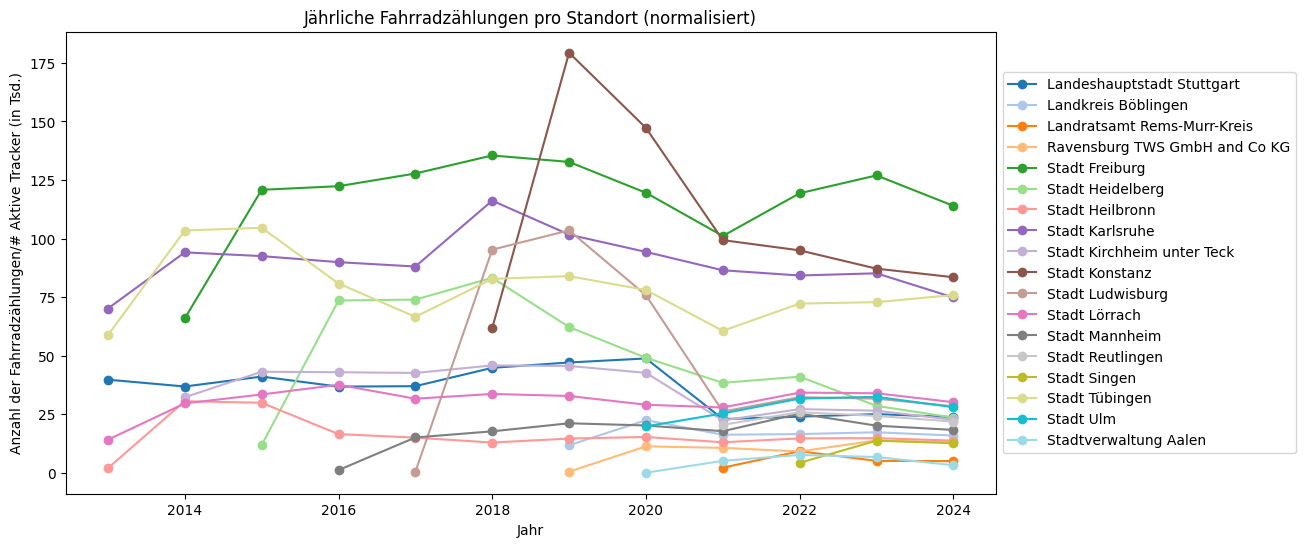

In [91]:
# Plot the normalized yearly counts per standort
def thousands(x, pos):
    return f'{int(x/1000)}'

standorte = normalized_yearly_counts['standort'].unique()
colors = cm.get_cmap('tab20', len(standorte))  # Colormap

plt.figure(figsize=(12, 6))
for i, standort in enumerate(standorte):
    subset = normalized_yearly_counts[normalized_yearly_counts['standort'] == standort]
    plt.plot(subset['year'], subset['normalized_yearly_counts'], marker='o',  # hier die Jahreswerte verwenden!
             label=standort, color=colors(i))

plt.title("Jährliche Fahrradzählungen pro Standort (normalisiert)")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Fahrradzählungen/# Aktive Tracker (in Tsd.)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# printe für jeden Standort die Anzahl der Datenpunkte
for location in data['standort'].unique():
    count = data[(data['standort'] == location)].shape[0]
    if count > 0:
        print(f"Standort: {location}, Anzahl der Datenpunkte: {count}")

#printe für jeden Standort alle Channel-Namen:
for location in data['standort'].unique():
    channel_names = data[data['standort'] == location]['channel_name'].unique()
    print(f"Standort: {location}, Channel Names: {channel_names}")

# printe für jeden Channel Name am Standort Stadt Freiburg die Anzahl der Datenpunkte:
for channel_name in data['channel_name'].unique():
    count = data[(data['standort'] == "Stadt Freiburg") & (data['channel_name'] == channel_name)].shape[0]
    if count > 0:
        print(f"Standort: Stadt Freiburg, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")

"""for location in data['standort'].unique():
    for channel_name in data['channel_name'].unique():
        count = data[(data['standort'] == location) & (data['channel_name'] == channel_name)].shape[0]
        if count > 0:
            print(f"Standort: {location}, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")
"""

Standort: Stadt Karlsruhe, Anzahl der Datenpunkte: 206892
Standort: Stadt Freiburg, Anzahl der Datenpunkte: 489217
Standort: Landeshauptstadt Stuttgart, Anzahl der Datenpunkte: 2654905
Standort: Stadt Tübingen, Anzahl der Datenpunkte: 959926
Standort: Stadt Lörrach, Anzahl der Datenpunkte: 312504
Standort: Stadt Heilbronn, Anzahl der Datenpunkte: 1729020
Standort: Stadt Mannheim, Anzahl der Datenpunkte: 1930194
Standort: Stadt Kirchheim unter Teck, Anzahl der Datenpunkte: 128278
Standort: Stadt Heidelberg, Anzahl der Datenpunkte: 2483704
Standort: Stadt Offenburg, Anzahl der Datenpunkte: 49785
Standort: Stadt Ludwisburg, Anzahl der Datenpunkte: 2164769
Standort: Stadt Konstanz, Anzahl der Datenpunkte: 603430
Standort: Landkreis Böblingen, Anzahl der Datenpunkte: 261962
Standort: Ravensburg TWS GmbH and Co KG, Anzahl der Datenpunkte: 1105946
Standort: Stadt Ulm, Anzahl der Datenpunkte: 170656
Standort: Stadtverwaltung Aalen, Anzahl der Datenpunkte: 136556
Standort: Stadt Reutlingen, Anz

'for location in data[\'standort\'].unique():\n    for channel_name in data[\'channel_name\'].unique():\n        count = data[(data[\'standort\'] == location) & (data[\'channel_name\'] == channel_name)].shape[0]\n        if count > 0:\n            print(f"Standort: {location}, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")\n'

In [26]:
# prüfe, für jeden Standort, wie viele Datenpunkte es gibt 
#for location in data['standort'].unique():
location = "Stadt Freiburg"
for site_id in data['counter_site_id'].unique():
    count = data[(data['standort'] == location) & (data['counter_site_id'] == site_id)].shape[0]
    if count > 0:
        print(f"Standort: {location}, Counter Side ID: {site_id}, Anzahl der Datenpunkte: {count}")

for channel_name in data['channel_name'].unique():
    count = data[(data['standort'] == location) & (data['channel_name'] == channel_name)].shape[0]
    if count > 0:
        print(f"Standort: {location}, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")            

Standort: Stadt Freiburg, Counter Side ID: 100004595, Anzahl der Datenpunkte: 103492
Standort: Stadt Freiburg, Counter Side ID: 100014511, Anzahl der Datenpunkte: 90482
Standort: Stadt Freiburg, Counter Side ID: 100014585, Anzahl der Datenpunkte: 120991
Standort: Stadt Freiburg, Counter Side ID: 100017109, Anzahl der Datenpunkte: 174252
Standort: Stadt Freiburg, Channel Name: Wiwilibrücke Querschnitt, Anzahl der Datenpunkte: 103492
Standort: Stadt Freiburg, Channel Name: FR2 Güterbahn / Ferd.-Weiß-Str., Anzahl der Datenpunkte: 90482
Standort: Stadt Freiburg, Channel Name: FR1 Dreisam / Otto-Wels-Str. Fahrräder 1 Nordfahrbahn stadteinwärts, Anzahl der Datenpunkte: 52536
Standort: Stadt Freiburg, Channel Name: Richtung Süden (Zelt 01_IN), Anzahl der Datenpunkte: 87126
Standort: Stadt Freiburg, Channel Name: Richtung Norden (Zelt 01_OUT), Anzahl der Datenpunkte: 87126
Standort: Stadt Freiburg, Channel Name: FR1 Dreisam / Otto-Wels-Str. Fahrräder, Anzahl der Datenpunkte: 68455


In [31]:
#printe für jeden Standort, Channel Name und Counter Site ID die Anzahl der Datenpunkte
for location in data['standort'].unique():
    data_standort = data[data['standort'] == location]
    for site_id in data_standort['counter_site_id'].unique():
        for channel_name in data_standort['channel_name'].unique():
            count = data[(data['standort'] == location) & (data['counter_site_id'] == site_id) & (data['channel_name'] == channel_name)].shape[0]
            if count > 0:
                print(f"Standort: {location}, Channel Name: {channel_name}, Counter Side ID: {site_id}, Anzahl der Datenpunkte: {count}")


Standort: Stadt Karlsruhe, Channel Name: Erbprinz. West, Counter Side ID: 100004165, Anzahl der Datenpunkte: 103446
Standort: Stadt Karlsruhe, Channel Name: Erbprinz Ost, Counter Side ID: 100004165, Anzahl der Datenpunkte: 103446
Standort: Stadt Freiburg, Channel Name: Wiwilibrücke Querschnitt, Counter Side ID: 100004595, Anzahl der Datenpunkte: 103492
Standort: Stadt Freiburg, Channel Name: FR2 Güterbahn / Ferd.-Weiß-Str., Counter Side ID: 100014511, Anzahl der Datenpunkte: 90482
Standort: Stadt Freiburg, Channel Name: FR1 Dreisam / Otto-Wels-Str. Fahrräder 1 Nordfahrbahn stadteinwärts, Counter Side ID: 100014585, Anzahl der Datenpunkte: 52536
Standort: Stadt Freiburg, Channel Name: FR1 Dreisam / Otto-Wels-Str. Fahrräder, Counter Side ID: 100014585, Anzahl der Datenpunkte: 68455
Standort: Stadt Freiburg, Channel Name: Richtung Süden (Zelt 01_IN), Counter Side ID: 100017109, Anzahl der Datenpunkte: 87126
Standort: Stadt Freiburg, Channel Name: Richtung Norden (Zelt 01_OUT), Counter Sid

In [38]:
from datetime import datetime

# prüfe für jeden Counter (Kombination aus Standort, Channel_name und Counter_Site_ID), 
# was der jeweils früheste und späteste timestamp ist
# schreibe standort, channel_name, frühester und spätester timestamp in pandas dataframe
start_end_timestamps = pd.DataFrame(columns=['standort', 'channel_name', 'counter_site_id', 'earliest_timestamp', 'latest_timestamp'])

for location in data['standort'].unique():
    data_standort = data[data['standort'] == location]
    for site_id in data_standort['counter_site_id'].unique():
        for channel_name in data_standort['channel_name'].unique():
            subset = data[(data['standort'] == location) & (data['counter_site_id'] == site_id) & (data['channel_name'] == channel_name)]
            if not subset.empty:
                earliest = subset['timestamp'].min().replace(tzinfo=None)
                latest = subset['timestamp'].max().replace(tzinfo=None)

                start_end_timestamps = pd.concat([start_end_timestamps, pd.DataFrame([{
                    'standort': location,
                    'channel_name': channel_name,
                    'counter_site_id': site_id,
                    'earliest_timestamp': earliest,
                    'latest_timestamp': latest
                }])], ignore_index=True)                       
                
    print(location)
                
    """if earliest > datetime(2013, 1, 1, 1, 0, 0) or latest < datetime(2024, 12, 31, 23, 0, 0):
    #datetime(2023, 11, 7, 14, 30, 0)  # Jahr, Monat, Tag, Stunde, Minute, Sekunde
        print(f"{location}, {channel_name}, Frühester Timestamp: {earliest}, Spätester Timestamp: {latest}")
    else:
        print(f"{location}, {channel_name}, passt zeitlich")"""


C:\Users\johan\AppData\Local\Temp\ipykernel_33532\3012212579.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  start_end_timestamps = pd.concat([start_end_timestamps, pd.DataFrame([{


Stadt Karlsruhe
Stadt Freiburg
Landeshauptstadt Stuttgart
Stadt Tübingen
Stadt Lörrach
Stadt Heilbronn
Stadt Mannheim
Stadt Kirchheim unter Teck
Stadt Heidelberg
Stadt Offenburg
Stadt Ludwisburg
Stadt Konstanz
Landkreis Böblingen
Ravensburg TWS GmbH and Co KG
Stadt Ulm
Stadtverwaltung Aalen
Stadt Reutlingen
Landratsamt Rems-Murr-Kreis
Stadt Singen


In [39]:
# schreibe start_end_timestamps in csv-datei
start_end_timestamps.to_csv("start_end_timestamps.csv", index=False)

#### More plots!

Course of the year 2023 in Konstanz (Counts per day)

In [47]:
location = 'Stadt Konstanz'
year = 2023
week = 32

In [22]:
konstanz_data = data[data['standort'] == location].copy()
konstanz_data['timestamp'] = pd.to_datetime(konstanz_data['timestamp'], errors='coerce')
konstanz_data.head()

konstanz_year_x = konstanz_data[konstanz_data['timestamp'].dt.year == year].copy()
konstanz_year_x['count'] = konstanz_year_x.iloc[:, 2]
daily_counts = konstanz_year_x.resample('D', on='timestamp')['count'].sum()
daily_counts.head()

timestamp
2023-01-01 00:00:00+00:00    4625
2023-01-02 00:00:00+00:00    8172
2023-01-03 00:00:00+00:00    7086
2023-01-04 00:00:00+00:00    8802
2023-01-05 00:00:00+00:00    9215
Freq: D, Name: count, dtype: int64

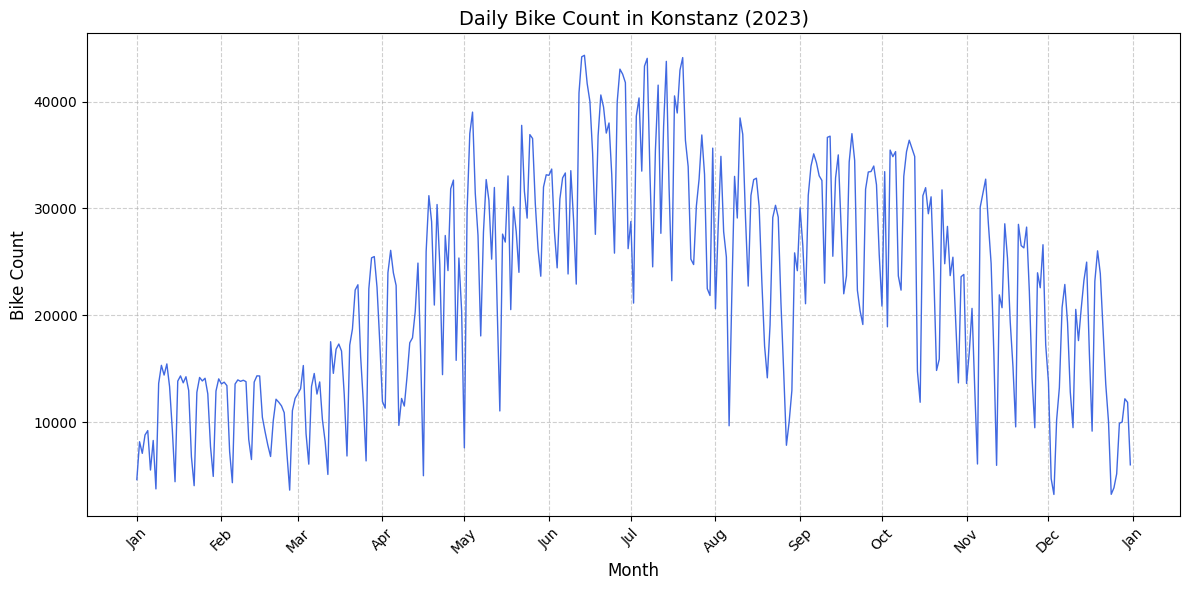

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, color='royalblue', linewidth=1)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Daily Bike Count in Konstanz (" + str(year) + ")", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Bike Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Exemplary week (2023, Konstanz)

In [25]:
konstanz_year_x['iso_year'] = konstanz_year_x['timestamp'].dt.isocalendar().year
konstanz_year_x['iso_week'] = konstanz_year_x['timestamp'].dt.isocalendar().week

# Filter for week 31
week_y = konstanz_year_x[
    (konstanz_year_x['iso_year'] == year) &
    (konstanz_year_x['iso_week'] == week)
    ].copy()
week_y['count'] = week_y.iloc[:, 2]
week_y_agg = (
    week_y
    .groupby('timestamp', as_index=False)
    .sum(numeric_only=True)  # sum across all numeric columns
    .sort_values('timestamp')
)
hourly_counts = week_y_agg[['timestamp', 'count']].copy()
peak_indices, _ = find_peaks(hourly_counts['count'], height=0)  # height=0 detects all local maxima
peak_times = hourly_counts['timestamp'].iloc[peak_indices]
peak_values = hourly_counts['count'].iloc[peak_indices]

hourly_counts.head()

,timestamp,count
0,2023-08-07 00:00:00+00:00,76
1,2023-08-07 01:00:00+00:00,36
2,2023-08-07 02:00:00+00:00,25
3,2023-08-07 03:00:00+00:00,17
4,2023-08-07 04:00:00+00:00,22


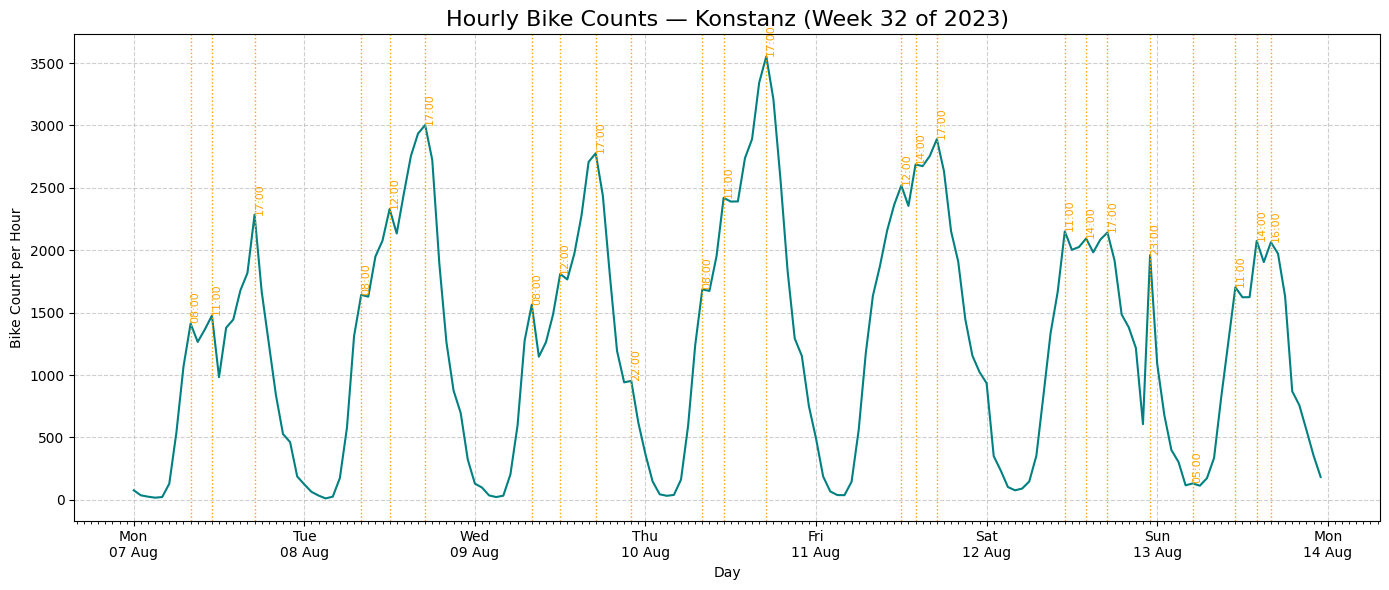

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(hourly_counts['timestamp'], hourly_counts['count'], color='teal', linewidth=1.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())  # one major tick per day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d %b'))

ax.xaxis.set_minor_locator(mdates.HourLocator())

for t, v in zip(peak_times, peak_values):
    plt.axvline(x=t, color='orange', linestyle=':', linewidth=1)
    plt.text(t, v + 1, t.strftime('%H:%M'), rotation=90, verticalalignment='bottom', color='orange', fontsize=8)

plt.xticks(rotation=0)

plt.title('Hourly Bike Counts — Konstanz (Week ' + str(week) + ' of ' + str(year) + ')', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Weekly pattern over the course of a year (year 2023, Konstanz)

C:\Users\grube\AppData\Local\Temp\ipykernel_9276\437816242.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  week_start = week_agg['timestamp'].dt.to_period('W').dt.start_time.iloc[0].tz_localize(week_agg['timestamp'].dt.tz)
C:\Users\grube\AppData\Local\Temp\ipykernel_9276\437816242.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  week_start = week_agg['timestamp'].dt.to_period('W').dt.start_time.iloc[0].tz_localize(week_agg['timestamp'].dt.tz)
C:\Users\grube\AppData\Local\Temp\ipykernel_9276\437816242.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  week_start = week_agg['timestamp'].dt.to_period('W').dt.start_time.iloc[0].tz_localize(week_agg['timestamp'].dt.tz)
C:\Users\grube\AppData\Local\Temp\ipykernel_9276\437816242.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  week_start =

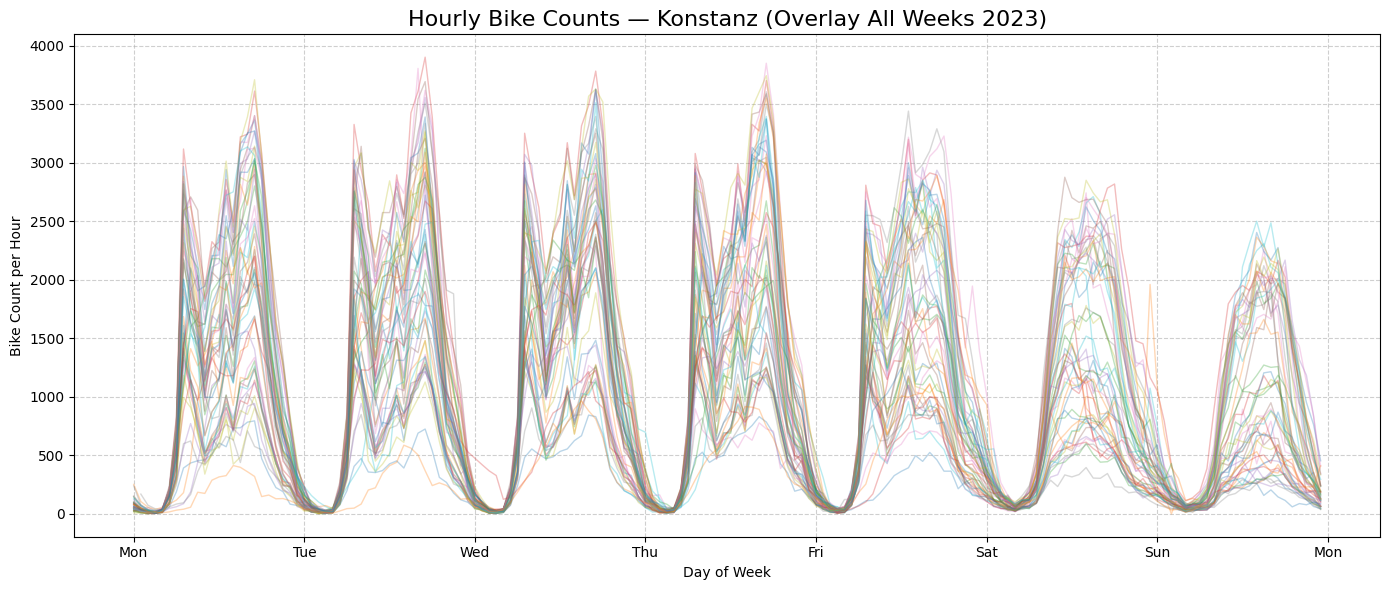

In [27]:
plt.figure(figsize=(14, 6))

# Loop over all weeks
for week in sorted(konstanz_year_x['iso_week'].unique()):
    week_data = konstanz_year_x[
        (konstanz_year_x['iso_year'] == year) &
        (konstanz_year_x['iso_week'] == week)
        ].copy()

    week_agg = week_data.groupby('timestamp', as_index=False)['count'].sum()

    # Normalize timestamps to a single week (tz-aware)
    week_start = week_agg['timestamp'].dt.to_period('W').dt.start_time.iloc[0].tz_localize(week_agg['timestamp'].dt.tz)
    week_agg['relative_time'] = (week_agg['timestamp'] - week_start).dt.total_seconds() / 3600  # hours since week start

    plt.plot(week_agg['relative_time'], week_agg['count'], alpha=0.3, linewidth=1)

# --- 3. Format x-axis to show day labels ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 24)))  # tick every day
ax.set_xticks([24 * i for i in range(8)])  # 0h, 24h, ..., 168h
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon'])

plt.title('Hourly Bike Counts — Konstanz (Overlay All Weeks ' + str(year) + ')', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Note: The daily pattern is overall the same. Especially interesting is that there seem to be several peaks throughout the day, which could be correlated with typical work times? Maybe we can find out more about which group uses bikes the most by looking at when bikes are used the most (like a "10am lecture peak")?

In [48]:
# Just to have an easy way to get the weather data for a specific calender week

def year_or_week_to_dates(year: int, week: int = None):
    """
    If 'week' is given, return Monday–Sunday of that ISO week.
    If 'week' is None, return Jan 1 – Dec 31 of that year.
    """
    if week is None:
        first_day = date(year, 1, 1)
        last_day = date(year, 12, 31)
    else:
        first_day = date.fromisocalendar(year, week, 1)
        last_day = first_day + timedelta(days=6)

    return str(first_day), str(last_day)


Weather data (only available for 2022-2025)

In [40]:
def get_weather_data():
    start_date, end_date = year_or_week_to_dates(year, week)

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    openmeteo = openmeteo_requests.Client(session=cache_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 47.66936,
        "longitude": 9.17467,
        "start_date": str(start_date),
        "end_date": str(end_date),
        "hourly": ["temperature_2m", "rain", "snowfall"],
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process hourly data. The order of variables needs to be the same as requested.
    response = responses[0]
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_rain = hourly.Variables(1).ValuesAsNumpy()
    hourly_snowfall = hourly.Variables(2).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ), "temperature_2m": hourly_temperature_2m, "rain": hourly_rain, "snowfall": hourly_snowfall}

    hourly_dataframe = pd.DataFrame(data=hourly_data)
    weather_data = hourly_dataframe[['date', 'rain', 'snowfall']].copy()
    # Convert rain and snowfall to True/False
    weather_data['rain'] = weather_data['rain'] > 0
    weather_data['snowfall'] = weather_data['snowfall'] > 0
    return weather_data

Note: I manually chose the coordinates of a specific counter. This is not 100% precise as there are several in konstanz. A more elaborated way to use this would be to obtain weather data for every device. On the other hand it probably makes no difference, the temperature and if it rains usually is the same for the whole city.

Fuse the bike data with the weather data in the given period of time

In [36]:
def fuse_bike_weather(bike_data, weather_data):
    bike_data = bike_data.copy()
    weather_data = weather_data.copy()

    bike_data['timestamp'] = pd.to_datetime(bike_data['timestamp'], utc=True)
    weather_data['date'] = pd.to_datetime(weather_data['date'], utc=True)

    weather_data = weather_data.rename(columns={'date': 'timestamp'})  # rename column for easier merge

    fused_data = pd.merge(bike_data, weather_data, on='timestamp', how='inner')  # merge

    return fused_data

In [50]:
weather_data = get_weather_data()
combined_data = fuse_bike_weather(hourly_counts, weather_data)
print(combined_data)

2023-08-07 2023-08-13
                    timestamp  count   rain  snowfall
0   2023-08-07 00:00:00+00:00     76  False     False
1   2023-08-07 01:00:00+00:00     36  False     False
2   2023-08-07 02:00:00+00:00     25  False     False
3   2023-08-07 03:00:00+00:00     17  False     False
4   2023-08-07 04:00:00+00:00     22  False     False
..                        ...    ...    ...       ...
163 2023-08-13 19:00:00+00:00    870  False     False
164 2023-08-13 20:00:00+00:00    758  False     False
165 2023-08-13 21:00:00+00:00    559  False     False
166 2023-08-13 22:00:00+00:00    355  False     False
167 2023-08-13 23:00:00+00:00    183  False     False

[168 rows x 4 columns]


Highlight rainy (or snowy) periods

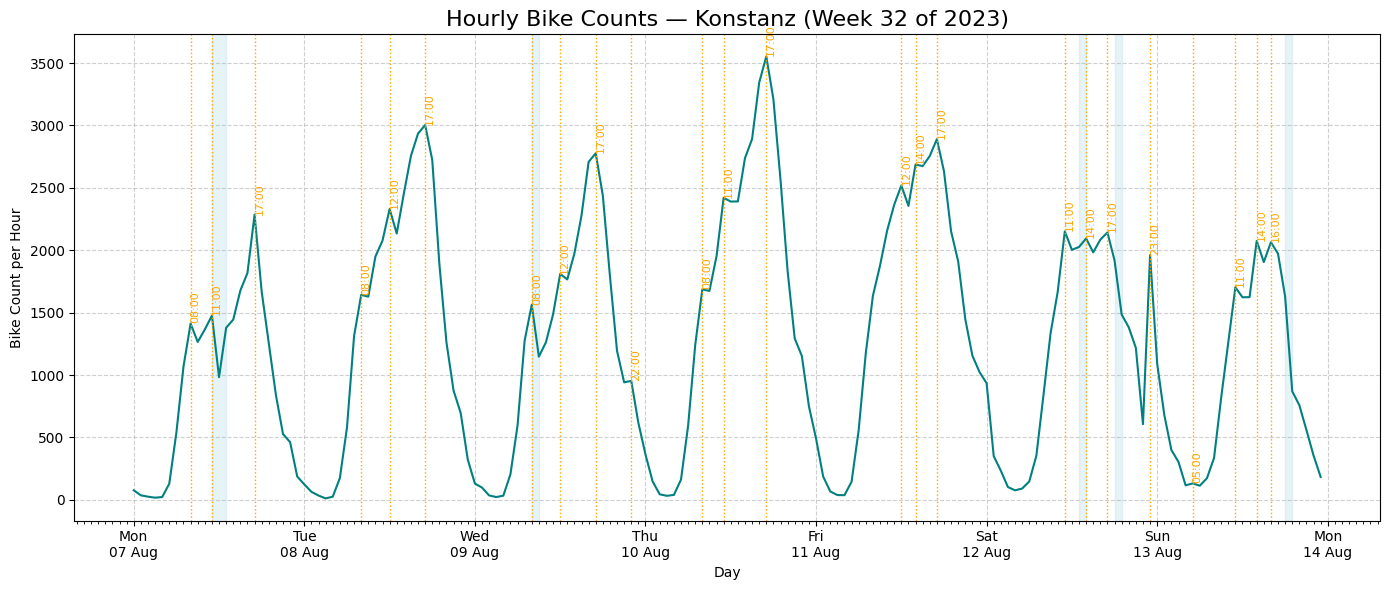

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(combined_data['timestamp'], combined_data['count'], color='teal', linewidth=1.5)

ax = plt.gca()

# --- Highlight rainy/snowy periods ---
# Find consecutive periods where rain or snow is True
in_weather = False
start_time = None

for i, row in combined_data.iterrows():
    if row['rain'] or row['snowfall']:
        if not in_weather:
            # Start of a rainy/snowy period
            start_time = row['timestamp']
            in_weather = True
    else:
        if in_weather:
            # End of a rainy/snowy period
            end_time = row['timestamp']
            ax.axvspan(start_time, end_time, color='lightblue', alpha=0.3)
            in_weather = False

# Catch if the last row is still in a rainy/snowy period
if in_weather:
    ax.axvspan(start_time, combined_data['timestamp'].iloc[-1], color='lightblue', alpha=0.3)

ax.xaxis.set_major_locator(mdates.DayLocator())  # one major tick per day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d %b'))

ax.xaxis.set_minor_locator(mdates.HourLocator())

for t, v in zip(peak_times, peak_values):
    plt.axvline(x=t, color='orange', linestyle=':', linewidth=1)
    plt.text(t, v + 1, t.strftime('%H:%M'), rotation=90, verticalalignment='bottom', color='orange', fontsize=8)

plt.xticks(rotation=0)

plt.title('Hourly Bike Counts — Konstanz (Week ' + str(week) + ' of ' + str(year) + ')', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Bike Count per Hour')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()